In [20]:
%pylab inline
pylab.rcParams['figure.figsize'] = 12,5

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [21]:
# This script will parse a CSV file taken from the Spectre Simulations and extract out the Early Voltage
import os
import sys
from scipy.optimize import leastsq, minimize
from pylab import *
import csv
import mpld3
from IPython.display import Image
from ipywidgets import interact, interactive, FloatSlider, Dropdown

This notebook will be used to extract various transistor properties from simulation, based on the All-Region MOSFET Model described in Schneider and Galup-Montoro's book.  As such, the parameters are with reference to how they are defined in this book.

# General functions

In [22]:
# This function reads a csv file and returns the raw data from the file,
# excluding the first line.  It will return the raw data as two lists: the first
# list will have the xVals, and the second array will have the yVals.
def readFile(filePath):
    data = genfromtxt(filePath, dtype=float, delimiter=",", skip_header=1)
    xVals = data[:,0::2]
    yVals = data[:,1::2]
    return xVals, yVals

# A function that allows the end-user to specify the type of plot he/she wants 
# to retrieve by various parameters.  Essentially, this is a wrapper on the 
# readFile function above.
def getData(folderRoot, FETType="NFET_eg1L", CurveType="IdsVgs", IDVal="_Vds0.1", printFN=False):
    fN = folderRoot + FETType + "_" + CurveType + "_" + IDVal + ".csv"
    if printFN:
        print fN
    xVals, yVals = readFile(fN)
    return xVals, yVals

# UT calculates the thermal voltage as a function of temperature (in Celsius), the value of
# electronic charge, and Boltzmann's constant.
def UT(degC):
    _k = 1.3806503e-23
    _q = 1.60217646e-19
    return(_k*(273.15+degC)/_q)

## Fitting algorithm functions

In [23]:
# fitLine takes data organized as columns of x,y pairs of data, and sorts through the columns to fit a line to each
# column's worth of data.  It returns an array for each output variable, m and b.  Each output array is of length = 
# number of columns
def fitLine(data):
    Xs, Ys = data
    ms = list()
    bs = list()
    numCols = shape(Ys)[1]
    for i in range(numCols):
        popt,pcov = leastsq(linFitErr, (0.00002, 0.00005), args=(Xs, Ys.T[i]))
        #print popt
        ms.append(popt[0])
        bs.append(popt[1])
    return array(ms), array(bs)

# linFit gets plots a line with slope m, and y-intercept b
def linFit(x, m, b):
    return m*x + b

# linFitErr calculates the difference between some data and a theoretical line with slope m, and
# y-intercept b.
def linFitErr(x0s, xData, yData):
    (m,b) = x0s
    return yData - linFit(xData, m, b)

# Fits the slope factor to extract gamma (the body-effect coefficient) and phi_F (Fermi Potential)
def SFParamEq(xData, gamma, phiF):
    invNOffsetSq = (4./(gamma**2))*(xData + (2.*phiF))
    return invNOffsetSq

# This function returns the residual to fitting the slope factor equation
# (as a function of gamma and phiF)
def SFParamEq_res(params, yData, xData):
    gamma, phiF = params
    err = yData - SFParamEq(xData, gamma, phiF)
    return err

# getEarlyVoltages finds the slope and y-intercept of the line that best fits the data
# for x-values above "threshold"
def getEarlyVoltages(origVds, origIds, threshold):
    mask = origVds>threshold
    if len(mask)<1:
        print "WARNING: Threshold might be set too high"
    ev_Vds = origVds[mask]
    ev_Ids = origIds[mask]
    
    Ms, Bs = fitLine((ev_Vds,ev_Ids))
    EarlyVoltages = calcEV(Ms, Bs)
    print "Early Voltages:\t", EarlyVoltages
    
    return (ev_Vds, ev_Ids, EarlyVoltages, Ms, Bs)

# calcEV takes the slope and y-intercept of a line and uses that to calculate the x-intercept.
# This allows the user to fit a linear line and calculate the Early Voltage from that.
def calcEV(m, b):
    return -b/m

## Plotting functions
### General plotting functions

In [589]:
# This function plots the derivative of the VpvsVg plot above.  As such, it gives
# the slopefactor as a function of Vp.
def plotDeriv(data, ttl="", color=(1,0,0), fntSz=12, xLbl='', yLbl=''):
    Xs, Ys = data
    dYs = diff(Ys)
    dXs = diff(Xs)
    plot(Xs[:-1], dYs/dXs, '.', color=color)
    xlabel(xLbl, fontsize=fntSz)
    ylabel(yLbl, fontsize=fntSz)
    #ylim([Ys.min()/10, Ys.max()*10])
    title(ttl)
    return dYs/dXs

### $I_{ds}$ based functions

In [24]:
def setXLim(Xs, xLims=None, minScale=0.9, maxScale=1.1):
    if xLims=="N":
        xlim(Xs.min()*minScale, 0)
    elif xLims=="P":
        xlim(0, Xs.max()*maxScale)
    elif xLims=='NP' or xLims=='PN':
        xlim(Xs.min()*minScale, Xs.max()*maxScale)
    elif type(xLims)==tuple:
        xlim(xLims)

def setYLim(Ys, yLims=None, minScale=0.9, maxScale=1.1):
    if yLims=="N":
        ylim(Ys.min()*minScale, 0)
    elif yLims=="P":
        ylim(0, Ys.max()*maxScale)
    elif yLims=='NP' or yLims=='PN':
        ylim(Ys.min()*minScale, Ys.max()*maxScale)
    elif type(yLims)==tuple:
        ylim(yLims)

def plotXY(data, ttl="Y vs X", marker='.', xLbl="X", yLbl="Y",
           color=(1,0,0), fntSz=16, xLims=None, yLims=None):
    Xs, Ys = data
    # Determine whether or not there are multiple columns worth of (x,y) plots.
    # If so, color code the plots from blue to red, otherwise, use the input color
    if len(shape(Ys))<=1:
        plot(Xs, Ys, marker=marker, color=color)
    else:
        numCols = shape(Ys)[1]
        for i in range(numCols):
            plot(Xs, Ys.T[i], marker=marker, color=(1.*i/(numCols-1), 0, 1.-(1.*i/(numCols-1))))
        
    xlabel(xLbl, fontsize=fntSz)
    ylabel(yLbl, fontsize=fntSz)
    setXLim(Xs, xLims, minScale=0.9, maxScale=1.1)
    setYLim(Ys, yLims, minScale=0.9, maxScale=1.1)
    title(ttl, fontsize=fntSz-4)

def plotXlogY(data, ttl="Log[Y] vs X", marker='.', xLbl="X", yLbl="Log[Y]",
              color=(1,0,0), fntSz=16, xLims=None, yLims=None):
    Xs, Ys = data
    # Determine whether or not there are multiple columns worth of (x,y) plots.
    # If so, color code the plots from blue to red, otherwise, use the input color
    if len(shape(Ys))<=1:
        semilogy(Xs, Ys, marker=marker, color=color)
    else:
        numCols = shape(Ys)[1]
        for i in range(numCols):
            semilogy(Xs, Ys.T[i], marker=marker, color=(1.*i/(numCols-1), 0, 1.-(1.*i/(numCols-1))))
            
    xlabel(xLbl, fontsize=fntSz)
    ylabel(yLbl, fontsize=fntSz)
    setXLim(Xs, xLims, minScale=0.1, maxScale=10)
    setYLim(Ys, yLims, minScale=0.1, maxScale=10)
    title(ttl, fontsize=fntSz-4)

    # This function plots the derivative of any data set.
def plotDeriv(data, ttl="dY vs X", marker='.', xLbl='X', yLbl='dY',
              color=(1,0,0), fntSz=16, xLims=None, yLims=None):
    Xs, Ys = data
    dYs = diff(Ys)
    dXs = diff(Xs)
    plot(Xs[:-1], dYs/dXs, marker=marker, color=color)
    xlabel(xLbl, fontsize=fntSz)
    ylabel(yLbl, fontsize=fntSz)
    setXLim(Xs, xLims, minScale=0.9, maxScale=1.1)
    setYLim(dYs, yLims, minScale=0.9, maxScale=1.1)
    title(ttl, fontsize=fntSz-4)
    return dYs/dXs

### $V_{gs}$ based functions
This sections includes plotting functions for transconductance as well.

In [25]:
def plotVgPlots(Vgs, Ids, ttl, color=(1,0,0)):
    gms = calcGm(Vgs, Ids)
    #print "gms", gms
    gmOverId = calcGmOverId(gms, Ids[:-1])
    #print "gm/Id", gmOverId
    #gmOverId = calcGmOverId_Vgs(Vgs, Ids)
    #print "gm/Id", gmOverId
    
    Vth, half_gmOverId = calcVth(Vgs, gmOverId)
    ISVal = calcIS(Vth, Vgs, Ids)
    
    subplot(1,3,1)
    plotXlogY((Vgs, Ids), ttl=ttl, xLbl=r'$V_{gs}$', color=color)
    # Use the threshold voltage calculated to plot a vertical line in the plot
    vlines(Vth, Ids.min()/10, Ids.max()*10,
           colors=color,
           linestyles='dashed')

    subplot(1,3,2)
    plotXlogY((Vgs[:-1], gms), 
               ttl=r'$g_m$ '+ttl, xLbl=r'$V_{gs}$', yLbl=r'$|g_m|$', color=color)
    
    subplot(1,3,3)
    plotXY((Vgs[:-1], gmOverId), 
               ttl=r'$g_m/I_{ds}$ '+ttl, xLbl=r'$V_{gs}$', yLbl=r'$g_m/I_{ds}$', color=color)
    # Use the threshold voltage calculated to plot a vertical line in the plot
    hlines(half_gmOverId, 0, 1,
           colors=color,
           linestyles='dashed')
    vlines(Vth, gmOverId.min()/10, gmOverId.max()*10,
           colors=color,
           linestyles='dashed')

    tight_layout()

    return Vth, ISVal, gms, gmOverId

# Plot a histogram of the gmOverId values to see what value I should be using for my maximum
def plotGmOverIdHist(gmOverIds, numBins=100, ttl=r'$g_m/I_d Histogram$', color=(1,0,0)):
    # Determine whether or not there are multiple columns worth of (x,y) plots.
    # If so, color code the plots from blue to red, otherwise, use the input color
    if len(shape(gmOverIds))<=1:
        hist(gmOverIds, bins=numBins, color=color, alpha=0.5, histtype="stepfilled")
    else:
        numCols = shape(gmOverIds)[1]
        for i in range(numCols):
            hist(gmOverIds.T[i], bins=numBins,
                 color=(1.*i/(numCols-1), 0, 1.-(1.*i/(numCols-1))), alpha=0.5,
                 histtype="stepfilled")
            
    avgMaxGmOverId, cnts = calcAvgMaxGmOverId(gmOverIds, numBins)
    xlabel(r'$g_m/I_d$', fontsize=fntSz)
    ylabel("Count", fontsize=fntSz)
    ylim([cnts.min(), cnts.max()*1.1])
    title(ttl)
    
    # Use the threshold voltage calculated to plot a vertical line in the plot
    vlines(max(gmOverIds), cnts.min(), cnts.max()*1.1,
           colors=color,
           linestyles='dotted')
    vlines(avgMaxGmOverId, cnts.min(), cnts.max()*1.1,
           colors=color,
           linestyles='dashed')
    #tight_layout()

    return avgMaxGmOverId

### Slope-factor based plots

In [26]:
def plotVpvsVg(data, ttl="", marker='', color=(1,0,0), fntSz=16):
    return plotXY(data, ttl=ttl, marker=marker, 
                  xLbl=r'$V_{p} (V_s)$', yLbl=r'$V_{g}$', color=color)
    
# This function plots the derivative of the VpvsVg plot above.  As such, it gives
# the slopefactor as a function of Vp.
def plotSlopeFactor(data, ttl="", marker='.',color=(1,0,0), fntSz=16):
    return plotDeriv(data, ttl=ttl, marker=marker, color=color, 
              fntSz=fntSz, xLbl=r'$V_{p} (V_s)$', yLbl=r'$n (1/\kappa)$')
    

# This function plots the slope factor (n) as a function of Vgb-Vs (Vgbs)
# It allows one to intuit how the slopefactor is changing for a given back-gate
# voltage, as per some of the analogies in the Trivedi '06 paper.
def plotSFvsVgbs(data, ttl="", marker='', color=(1,0,0), fntSz=16):
    return plotXY(data, ttl=ttl, marker=marker, xLbl=r'$V_{gbs}$', yLbl=r'$n$',
                  color=color)

# This function plots the 1/(n-1)^2 data vs Vps
# Input to this function are two arrays, Vps and Ns
def plotSFParamData(data, ttl="", marker='.', color=(1,0,0), fntSz=16):
    Xs, Ns = data
    Ys = calcInvNOffSq(Ns)
    
    plotXY((Xs,Ys), ttl=ttl, marker=marker,
           xLbl=r'$V_{p} (V_s)$', yLbl=r'$1/(n-1)^2$', color=color)
    return Ys

## Extraction functions

### Helper calculator functions

In [27]:
# calculate transcondutance if given two arrays, Vg values and Id Values, respectively
# Note: if the arrays are multidimensional, they should be arranged so that each
#     row corresponds to the array of Vg or Id values, respectively.
def calcGm(Vgs, Ids):
    return abs(diff(Ids))/diff(Vgs)

# Takes Vgs and Ids and returns an array of gm/Id
# This function is an alternative to calcGmOverId below
#    Vgs: array of Vg values
#    Ids: array of Id values
# Note: these two arrays must be of the same size.
def calcGmOverId_Vgs(Vgs, Ids):
    return abs(diff(log(Ids)))/diff(Vgs)

# Takes gms and Ids and returns an array of gm/Id
#    gms: array of transconductances
#    Ids: array of Id values
# Note: these two arrays must be of the same size.
def calcGmOverId(gms, Ids):
    return gms/Ids

# This function takes an array of gmOverId values and a bin count and returns
#   the average maximum value of the array.  This allows us to filter out some
#   of the odd bumps and drops that happen in these plots
def calcAvgMaxGmOverId(gmOverIds, numBins=100):
    (cnts, binBoundaries) = histogram(gmOverIds, numBins)
    #print "Counts:", cnts
    #print "Bins:", binBoundaries
    mask = argmax(cnts)    # Find the index where the maximum count is first found
    #print mask, binBoundaries[mask], mask+1, binBoundaries[mask:mask+2]
    avgMaxGmOverId = mean(binBoundaries[mask:mask+2])
    #print avgMaxGmOverId
    return avgMaxGmOverId, cnts

# This function takes the gmOverId values and the Vgs values and returns Vth
#    Vgs: array of gate voltages corresponding to the gm/Id values
#    gmOverID: array of gm/Id values
def calcVth(Vgs, gmOverId):
    # Calculate the threshold voltage from the last plot's data
    #half_gmOverId = gmOverId.max(axis=0)*0.53  #from S&GM, p.462, footnote 1
    # Use the steady-state maximum value instead of the exact outlier value.
    avgMaxGmOverId, cnts = calcAvgMaxGmOverId(gmOverId, numBins=100)
    half_gmOverId = avgMaxGmOverId*0.53  #from S&GM, p.462, footnote 1
    #print "Half of max(gm/Id ratio):", half_gmOverId
    li = int(len(gmOverId)*0.15)  # Lower Index value to use to test for NFET vs PFET
    ui = int(len(gmOverId)*0.85)  # Upper Index value to use to test for NFET vs PFET
    
    #print li, ui
    #print gmOverId[li], gmOverId[ui]
    
    if gmOverId[li]>gmOverId[ui]:   # FETType is an NFET
        Vth = Vgs[where(gmOverId>=half_gmOverId)][-1]
        #print "NFET"
    else:    # FETType is a PFET FETType=="P"
        Vth = Vgs[where(gmOverId>=half_gmOverId)][0]
        #print "PFET"
    #print "Vth: ", Vth
    return Vth, half_gmOverId
    

# This function takes a threshold voltage and two arrays as arguments
#    Vth: threshold voltage
#    Vgs: array of gate voltages corresponding to the Id values
#    Ids: array of Id values
# Returns the specific current for this transistor, at Vth.
# Note the returned value may be an array if the input Vgs and Ids values are 
# multi-dimensional (MxN) arrays.  If this is the case, end-user must be sure to
# grab the correct values that he/she wants from the result N-element long array
def calcIS(Vth, Vgs, Ids):
    
    Vth_idx = where(Vgs[:]==Vth)
    #print "Vth_idx:", Vth_idx
    #print Ids[Vth_idx], Ids[Vth_idx][0]
    IS = Ids[Vth_idx]*1.13 # from S&GM, p.462, Footnote 1
    #print "IS Val: ", IS
    return IS

# This function takes a value for n and returns 1/(n-1)^2
def calcInvNOffSq(N):
    return 1./((N-1)**2)

# This fucntion takes a value for 1/(n-1)^2 and returns n
def calcN(invNOffSq):
    return sqrt(1./invNOffSq)+1

# This function returns the derivative values for any data set
def calcDeriv(data):
    Xs, Ys = data
    dYs = diff(Ys)
    dXs = diff(Xs)
    return dYs/dXs

### Helper get functions

In [28]:
# This function will take a scalar value of a drain current and return the
#   corresponding V (Vg or Vd) value for it.
#   The V Val returned is based on the curveType of the plot
# IVal: scalar
# VVals: 1D Array of voltage values
# IVals: 1D Array of current values
def getVVal(IVal, VVals, IVals):
    #print "Mean of difference: ", mean(diff(yVals[:,i]))
    if mean(diff(IVals))<0:  # implies that Ivals decrease as Vvals increase
        #print "Device is PFET"
        Vg = VVals[where(IVals<=IVal)[0][0]]
    else:
        #print "Device is NFET"
        Vg = VVals[where(IVals<=IVal)[0][-1]]
    #print Vg
    return Vg

# This function will take a scalar value of a voltage and return the
#   drain current  I value corresponding to it
# VVal: scalar value (either Vg or Vd)
# VVals: 1D Array of voltage values
# IVals: 1D Array of current values
# Note: This function assumes that VVals is always smallest to largest (sorted)
def getIVal(VVal, VVals, IVals):
    Id = IVals[where(VVals<=VVal)[0][-1]]
    #print Id
    return Id

### Compare FETs function
This function allows us to plot $V_g$ plots of one type of FET vs another

In [29]:
def compareFETs(FETTypes, folderRoots, ttl, curveType="IdsVgsCurve", printFN=False):
    FETType1, FETType2 = FETTypes
    folderRoot1, folderRoot2 = folderRoots
    
    numTemps = len(temps)
    maxY = 0
    
    Vths1 = list()
    ISs1 = list()
    Vths2 = list()
    ISs2 = list()
    
    for i, curTemp in enumerate(temps):
        Vd = Vds[i]
        #print 
        print "Temp:", curTemp, "\tVds:", Vd

        Vgs1, Ids1 = getData(folderRoot1, FETType=FETType1,
                                                CurveType=curveType, IDVal="Vds"+str(Vd), printFN=printFN)
        Vgs2, Ids2 = getData(folderRoot2, FETType=FETType2,
                                                CurveType=curveType, IDVal="Vds"+str(Vd), printFN=printFN)

        Vth1, IS1, gms1, gmOverId1 = plotVgPlots(Vgs1[:,i], Ids1[:,i],
                                        ttl=ttl, color=(1.*i/(numTemps-1), 0, 1-(1.*i/(numTemps-1))))
        #print "Vth1:\t", Vth1, "\nIS1:\t", IS1
        Vths1.append(Vth1)
        ISs1.append(IS1[0])

        Vth2, IS2, gms2, gmOverId2 = plotVgPlots(Vgs2[:,i], Ids2[:,i],
                                        ttl=ttl, color=(1.*i/(numTemps-1), 0.5, 1-(1.*i/(numTemps-1))))
        #print "Vth2:\t", Vth2, "\nIS2:\t", IS2
        Vths2.append(Vth2)
        ISs2.append(IS2[0])

        maxY = max( [maxY, 1.1*max( gmOverId1.flatten() ), 1.1*max( gmOverId2.flatten() )] )
        #print "Max Y:", maxY
        ylim((0,maxY))
        
    print "Vth (",FETType1,"):", Vths1, "\nVth (",FETType2,"):", Vths2
    print "IS (",FETType1,"):", ISs1, "\nIS (",FETType2,"):",ISs2
    for i, curTemp in enumerate(temps):
        #print UT(curTemp)**2
        print 'IS1_norm(',curTemp,'):', ISs1[i]/(UT(curTemp)**2)
        print 'IS2_norm(',curTemp,'):', ISs2[i]/(UT(curTemp)**2)
            
    
    return Vths1, ISs1, Vths2, ISs2

### Get max $g_m/I_d$ from a set of curves
This function will plot the histograms and calculate the average maximum value of $g_m/I_d$

In [692]:
def getMaxGmOverIdFunc(FETType, folderRoot, ttl, curveType="IdsVgsCurve", printFN=False, colorSkew=0):
    numTemps = len(temps)
    maxY = 0
    
    for i, curTemp in enumerate(temps):
        Vd = Vds[i]
        #print 
        print "Temp:", curTemp, "\tVds:", Vd

        Vgs, Ids = getData(folderRoot, FETType=FETType,
                                                CurveType=curveType, IDVal="Vds"+str(Vd), printFN=printFN)
        gms = calcGm(Vgs[:,i], Ids[:,i])
        #print "gms", gms
        gmOverId = calcGmOverId(gms, Ids[:,i][:-1])
        #print "gm/Id", gmOverId
        #subplot(1,numTemps,i+1)
        maxGmOverId = plotGmOverIdHist(gmOverId[gmOverId>max(gmOverId)*0.8], 200, 
                               ttl ,color=(1.*i/(numTemps-1), colorSkew, 1-(1.*i/(numTemps-1))))
        print maxGmOverId
    tight_layout()

### Slope factor functions

In [30]:
def getSFParams(Vps, invNOffSqs, p0):
    #print len(Vps), Vps
    #print len(invNOffSqs), invNOffSqs
    #Ys = 1/((Ns-1)**2)
    params = leastsq(SFParamEq_res, p0, args=(invNOffSqs, Vps))
    #print "Leastsq return values: ", params
    
    #Once we have scipy ver 18+, this following bounded least square operation will hopefully work
    #params = least_squares(SFParamEq_res, p0, args=(invNOffSqs, Vps), bounds=((-inf, inf), (-1,1)))
    #print params[0]
    gamma, phiFermi = params[0]
    #print "Fitted Gamma:", gamma, "\t Fitted V_fermi:", phiFermi
    return gamma, phiFermi

def slopeFactor(folderRoot, FETType="NFET", curveType="VgvsVs_KappaExtraction",
                temps=[25], ttl=None, xLims=(0,1), yLims=None, printFN=False,
                plotIdx=0, Vdd=None, Vth=None):
    numTemps = len(temps)
    SFs = list()
    gammas = list()
    vFermis = list()
    j = plotIdx
    if ttl==None:
        ttl = FETType
        
    for i, curTemp in enumerate(temps):
        #print
        #print "Temp:", curTemp
        curColor = (1.*i/(numTemps-1), 1.*j/(numTemps-1), 1-(1.*i/(numTemps-1)))

        Vps, Vgs = getData(folderRoot, FETType=FETType,
                           CurveType=curveType, IDVal="T"+str(int(curTemp))+"C", printFN=printFN)
        # Plot of pinch-off voltage vs gate voltage
        subplot(1,3,1)
        plotVpvsVg((Vps[:,j+1],Vgs[:,j+1]), ttl="$V_p vs V_g$: "+ttl,
                    color=curColor, fntSz=14)
        xlim(xLims)

        # Plot of slope factor vs Vgs
        subplot(1,3,2)
        curSFs = plotSlopeFactor((Vps[:,j+1],Vgs[:,j+1]), ttl="$n (1/\kappa)$: "+ttl,
                    color=curColor, fntSz=14)
            
        xlim(xLims)
        ylim(yLims)
        #print array(curSFs)
        SFs.append(array(curSFs))
        #print Vps[:-1,i]-(1/array(curSFs)*Vgs[:-1,j+1])
               
        # Plot of 1/(n-1)^2 vs Vp curve
        subplot(1,3,3)
        #print curSFs
        Ns = array(curSFs)
        if xLims!=None:
            mask = where((Vgs[:,j+1]>=min(xLims))*(Vgs[:,j+1]<max(xLims)))[0]
        else:
            mask = where((Vgs[:,j+1]>=min(Vgs[:,j+1]))*(Vgs[:,j+1]<max(Vgs[:,j+1])))[0]
            mask = mask - min(mask)
        gamma, phiFermi = getSFParams(Vgs[mask,0], calcInvNOffSq(Ns)[mask], (0.5, 0.5))
        gammas.append(gamma)
        vFermis.append(phiFermi)
        #print "Extracted Gamma, and FermiV:", gamma, phiFermi
        #print shape(Vps[mask,0]), shape(Ns[mask])
        plotSFParamData((Vgs[mask,0], Ns[mask]),
                        ttl="$1/(n-1)^2$ vs Vp: "+ttl,
                        color=curColor,
                        fntSz=14)
        
        plot(Vgs[mask,0],SFParamEq(Vgs[mask,0], gamma, phiFermi),'--',
                       color=(1.*i/(numTemps-1), 1.*j/(numTemps-1), 1-(1.*i/(numTemps-1)),0.5))
    tight_layout()
    # Returns the average slope factor value
    return array(SFs), array(gammas), array(vFermis)

# This will plot some of the advanced slopeFactor-based information
# Included in this is a breakdown of the slopefactor with respect to Vgbs
# The derivative (dSF) of the slopefactor plot with respect to Vgbs.
def advSFInfo(folderRoot, FETType="NFET", curveType="VgvsVs_KappaExtraction",
                temps=[25], ttl=None, xLims=(0,1), yLims=None, printFN=False,
                plotIdx=0, Vdd=None, Vth=None):
    numTemps = len(temps)
    
    j = plotIdx
    if ttl==None:
        ttl = FETType
        
    for i, curTemp in enumerate(temps):
        curColor = (1.*i/(numTemps-1), 1.*j/(numTemps-1), 1-(1.*i/(numTemps-1)))

        Vps, Vgs = getData(folderRoot, FETType=FETType,
                           CurveType=curveType, IDVal="T"+str(int(curTemp))+"C", printFN=printFN)
        curSFs = calcDeriv((Vps[:,j+1],Vgs[:,j+1]))
        
        # Plot of slope factor vs Vgs
        plotSFvsVgbs((Vgs[:-1,0],curSFs), ttl="$n (1/\kappa)$: "+ttl,
                    color=curColor, fntSz=14)
        
        curMin = curSFs.min()*0.999
        curMax = curSFs.max()*1.001
        grayColor = 0.5
        curGray = (grayColor,grayColor,grayColor)

        if Vth:
            vlines(Vth, curMin, curMax, colors=curGray, linestyles='dashed')
            vlines(-Vth, curMin, curMax, colors=curGray, linestyles='dashed')
    tight_layout()

## Printing functions

In [31]:
# Note: SFs should have the same number of dimensions as temps has length
def printSFData(temps, SFs):
    for i, curSFs in enumerate(SFs):
        print "Temp: ", temps[i]
        print "Mean SFs:", mean(array(curSFs)), "\tMean kappa:", mean(1/array(curSFs))
        print "Min SFs:", array(curSFs).min(), "\tMin kappa:", (1/array(curSFs)).min()
        print "Max SFs:", array(curSFs).max(), "\tMax kappa:", (1/array(curSFs)).max()
        
def printGammaData(gammas):
    print "Fitted Gammas:", gammas
    
def printFermiData(vFermis):
    print "Fitted V_fermis:", vFermis
    
def printSFInfo(temps, SFs, gammas, vFermis):
    printSFData(temps, SFs)
    printGammaData(gammas)
    printFermiData(vFermis)

# Get general data from the files

In [32]:
folderRoot = "/home/noza/work/data/FET_tests/ExtractParams/"

#paramFileName = folderRoot + "ParamAnalysisVals_VgSweep.csv"
#with open(paramFileName) as pfn:
#    reader = csv.reader(pfn)
#    data = list()
#    for i, row in enumerate(reader):
#        data.append(double(row[1:]))
#Vgs = data[0]
#print "Vg Vals:", Vgs
paramFileName = folderRoot + "ParamAnalysisVals_ohmicVdsTempSweep_IdVgsPlot.csv"
with open(paramFileName) as pfn:
    reader = csv.reader(pfn)
    data = list()
    for i, row in enumerate(reader):
        data.append(double(row[1:]))
#print data
Vds = data[0]
print "Vd Vals:", Vds
if len(data)>1:
    temps = data[1]
    print "Temp Vals:", temps

Vd Vals: [ 0.012  0.013  0.014]
Temp Vals: [  0.  25.  50.]


# Extract Parameters

## Plot $I_{ds}$ vs $V_{ds}$

NameError: name 'origVds_1L' is not defined

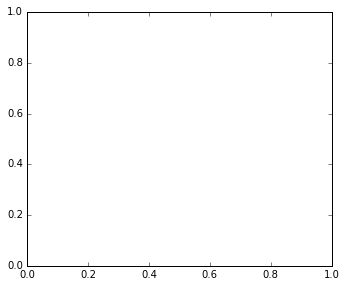

In [445]:
figsize(12,10)
subplot(2,2,1)
plotIds((origVds_1L, origIds_1L_Vds*1e6),
        ttl="Thin-FET, 1L, Varying $V_{gs}$", xLbl=r'$V_{ds}$', yLbl=r'$I_d (\mu A)$')
subplot(2,2,2)
plotIds((origVds_3L, origIds_3L_Vds*1e6),
        ttl="Thin-FET, 3L, Varying $V_{gs}$", xLbl=r'$V_{ds}$', yLbl=r'$I_d (\mu A)$')
subplot(2,2,3)
plotIds((origVds_eg1L, origIds_eg1L_Vds*1e6),
        ttl="Thick-FET, 1L, Varying $V_{gs}$", xLbl=r'$V_{ds}$', yLbl=r'$I_d (\mu A)$')
subplot(2,2,4)
plotIds((origVds_eg3L, origIds_eg3L_Vds*1e6),
        ttl="Thick-FET, 3L, Varying $V_{gs}$", xLbl=r'$V_{ds}$', yLbl=r'$I_d (\mu A)$')
tight_layout()
show()

## Plot $I_{ds}$, $g_m$, and $\frac{g_m}{I_{ds}}$ vs $V_{gs}$
From the transconductance-to-current plot, we'll be able to extract $I_S$ and $V_T$
### Thick-Oxide
#### Short Channel (1L, 150nm)

Temp: 0.0 	Vds: 0.012
Temp: 25.0 	Vds: 0.013
Temp: 50.0 	Vds: 0.014
Vth ( NFET_eg1L ): [0.65500000000000047, 0.64200000000000046, 0.62600000000000044] 
Vth ( PFET_eg1L ): [0.27700000000000019, 0.29600000000000021, 0.31400000000000022]
IS ( NFET_eg1L ): [1.2592941603526467e-07, 1.4074595334726164e-07, 1.4828965266114836e-07] 
IS ( PFET_eg1L ): [2.2135383902652442e-07, 2.4811188795822389e-07, 2.7634836189820236e-07]
IS1_norm( 0.0 ): 0.000227288828227
IS2_norm( 0.0 ): 0.000399519479084
IS1_norm( 25.0 ): 0.000213215905777
IS2_norm( 25.0 ): 0.000375864454124
IS1_norm( 50.0 ): 0.000191229917357
IS2_norm( 50.0 ): 0.000356370612914


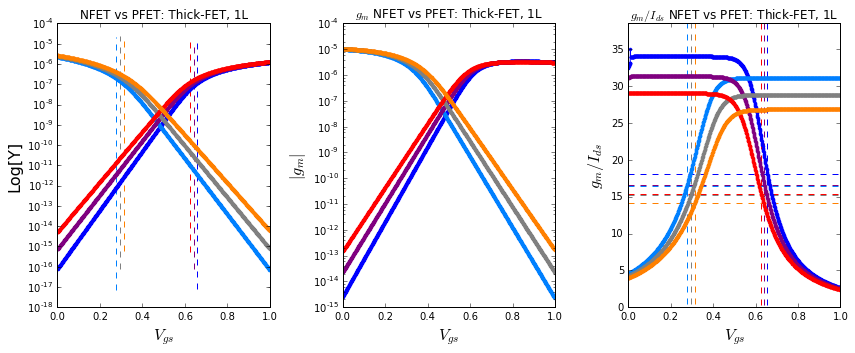

In [19]:
Vths_N_eg1L, IS_N_eg1L, Vths_P_eg1L, IS_P_eg1L = compareFETs(("NFET_eg1L", "PFET_eg1L"), 
            (folderRoot, folderRoot),
            "NFET vs PFET: Thick-FET, 1L",
            curveType="IdsVgsCurve")

Compare where the maximum slope of the gm/Id plot occurs at relative to the threshold voltage.

Temp: 0.0 	Vds: 0.012
/home/noza/work/data/FET_tests/ExtractParams/NFET_eg1L_IdsVgsCurve_Vds0.012.csv
169.794821949
[ 0.628]
Temp: 25.0 	Vds: 0.013
/home/noza/work/data/FET_tests/ExtractParams/NFET_eg1L_IdsVgsCurve_Vds0.013.csv
144.331199018
[ 0.611]
Temp: 50.0 	Vds: 0.014
/home/noza/work/data/FET_tests/ExtractParams/NFET_eg1L_IdsVgsCurve_Vds0.014.csv
124.192839691
[ 0.594]


/opt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/opt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/opt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/opt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/opt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/opt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: DeprecationWarning: using a non-integer number instead of

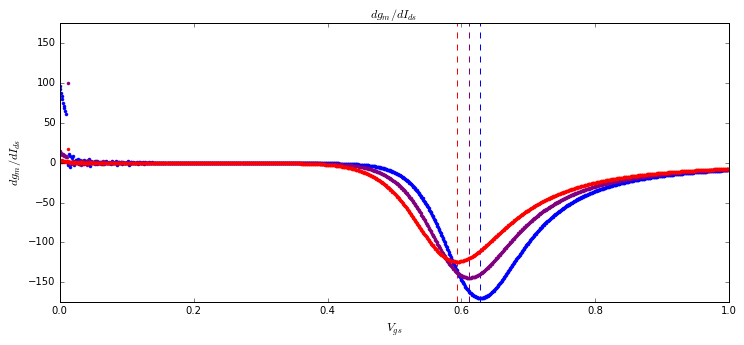

In [637]:
numTemps = len(temps)
for i, curTemp in enumerate(temps):
    Vd = Vds[i]
    #print 
    print "Temp:", curTemp, "\tVds:", Vd    
    Vgsfoo, Idsfoo = getData(folderRoot, FETType="NFET_eg1L",CurveType="IdsVgsCurve", IDVal="Vds"+str(Vd), printFN=True)
    gmsfoo = calcGm(Vgsfoo[:,i], Idsfoo[:,i])
    gmOverIdfoo = calcGmOverId(gmsfoo,Idsfoo[:-1,i])
    col = (1.*i/(numTemps-1), 0, 1-(1.*i/(numTemps-1)))
    
    derivs = plotDeriv((Vgsfoo[:-1,i],gmOverIdfoo),
              ttl=r'$dg_m/dI_{ds}$ ', xLbl=r'$V_{gs}$', yLbl=r'$d g_m/d I_{ds}$',
              color=col)
    curMaxDeriv = max(abs(derivs[0.1*len(derivs):-0.1*len(derivs)]))
    print curMaxDeriv
    Vth = Vgsfoo[where(abs(derivs)==curMaxDeriv),i][-1]
    print Vth
    yLim = 175
    ylim((-yLim,yLim))
    vlines(Vth, -yLim, yLim, colors=col, linestyles='dashed')


We see from the plot above that the threshold voltage calculated using the approach in S&GM is different from the results gotten using the maximum slope of the $g_m/I_d$ plot.  There is no reason to believe that the maximum slope of gm/Id would result in the correct threshold voltage, but I was curious how closely it would be to the $\frac{max(g_m/I_d)}{2}$ point.

#### Long Channel (1Txr, 450nm)

Temp: 0.0 	Vds: 0.012
Temp: 25.0 	Vds: 0.013
Temp: 50.0 	Vds: 0.014
Vth ( NFET_eg3L ): [0.65800000000000047, 0.64700000000000046, 0.63100000000000045] 
Vth ( PFET_eg3L ): [0.30500000000000022, 0.32900000000000018, 0.35200000000000031]
IS ( NFET_eg3L ): [4.5339835562226938e-08, 5.3500456931882252e-08, 5.6736093139150413e-08] 
IS ( PFET_eg3L ): [9.1178580362113206e-09, 9.9626453726181503e-09, 1.086840943541093e-08]


/opt/anaconda/lib/python2.7/site-packages/IPython/core/formatters.py:90: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/opt/anaconda/lib/python2.7/site-packages/IPython/core/formatters.py:667: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


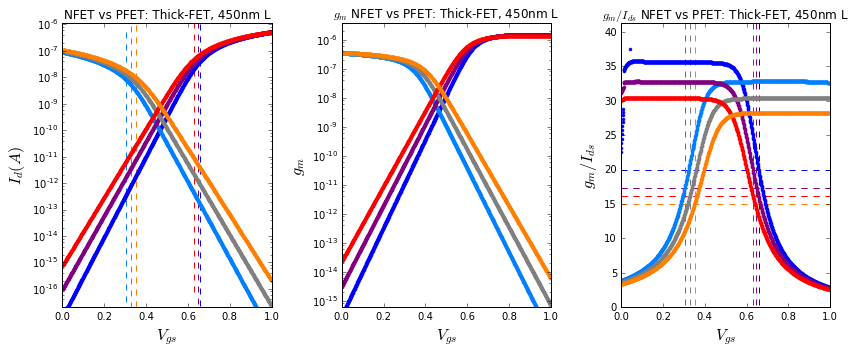

In [25]:
Vths_N_eg3L, IS_N_eg3L, Vths_P_eg3L, IS_P_eg3L = compareFETs(("NFET_eg3L", "PFET_eg3L"), 
            (folderRoot, folderRoot_P),
            "NFET vs PFET: Thick-FET, 450nm L",
            curveType="IdsVgsCurve")

Try measuring Vth using the average max value (in steady state, rather than the absolute maximum)

Temp: 0.0 	Vds: 0.012
Temp: 25.0 	Vds: 0.013
Temp: 50.0 	Vds: 0.014
Vth ( NFET_eg3L ): [0.66400000000000048, 0.64800000000000046, 0.63100000000000045] 
Vth ( PFET_eg3L ): [0.30500000000000022, 0.32800000000000018, 0.35100000000000031]
IS ( NFET_eg3L ): [5.0899786111457675e-08, 5.443619783975373e-08, 5.6736093139150413e-08] 
IS ( PFET_eg3L ): [9.1178580362113206e-09, 1.0125408859486612e-08, 1.1033666471586833e-08]


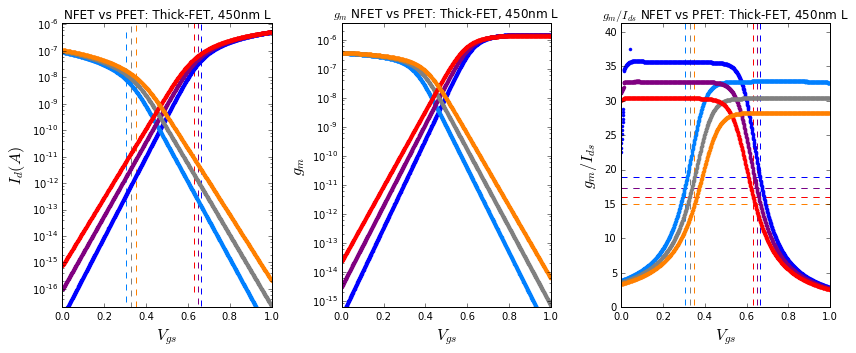

In [145]:
Vths_N_eg3L, IS_N_eg3L, Vths_P_eg3L, IS_P_eg3L = compareFETs(("NFET_eg3L", "PFET_eg3L"), 
            (folderRoot, folderRoot_P),
            "NFET vs PFET: Thick-FET, 450nm L",
            curveType="IdsVgsCurve")

Note: The specific currents for a longer channel device aren't exactly 3 times smaller than the specific current of the smaller devices above.  Why is this the case?

#### Long Channel (1Txr, 1500nm)

Temp: 0.0 	Vds: 0.012
Temp: 25.0 	Vds: 0.013
Temp: 50.0 	Vds: 0.014
Vth ( NFET_eg10L ): [0.66700000000000048, 0.65000000000000047, 0.63400000000000045] 
Vth ( PFET_eg10L ): [0.26900000000000018, 0.2900000000000002, 0.31000000000000022]
IS ( NFET_eg10L ): [1.6778379578247047e-08, 1.736202358708574e-08, 1.8159375168218346e-08] 
IS ( PFET_eg10L ): [1.888044938593765e-08, 2.0839075925264883e-08, 2.2940517230939051e-08]


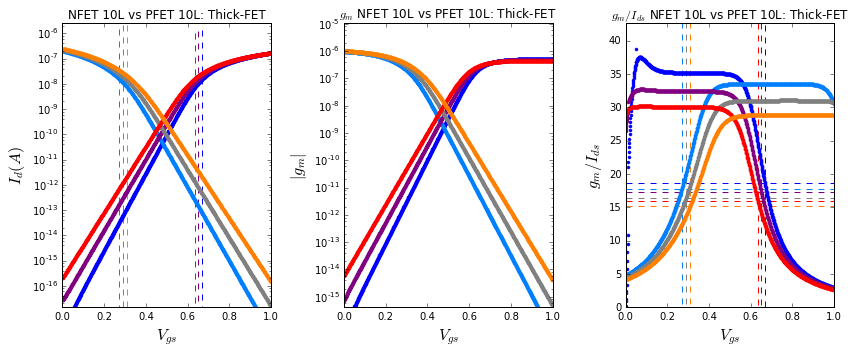

In [252]:
Vths_N_eg10L, IS_N_eg10L, Vths_N_eg1L, IS_N_eg1L = compareFETs(("NFET_eg10L", "PFET_eg10L"), 
            (folderRoot, folderRoot),
            "NFET 10L vs PFET 10L: Thick-FET",
            curveType="IdsVgsCurve")

This is a measurement that shows what the average max value of $g_m/I_d$ is relative to the old maximum value that was used.  The new value is shown by the dashed line, while the old max value is shown as the dotted lines.  This will hopefully help us find an even more accurate $V_{th}$, and therefore more accurate specific current, $I_s$

Temp: 0.0 	Vds: 0.012
35.7926238779
Temp: 25.0 	Vds: 0.013
32.9893315134
Temp: 50.0 	Vds: 0.014
30.5540043931
Temp: 0.0 	Vds: 0.012
32.9766044841
Temp: 25.0 	Vds: 0.013
30.535822937
Temp: 50.0 	Vds: 0.014
28.4313296009


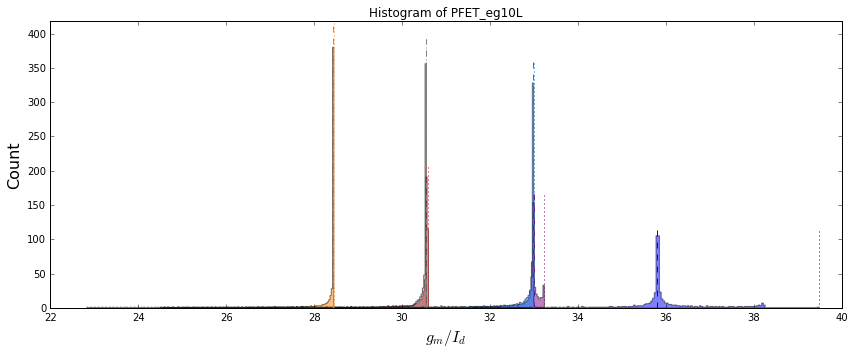

In [212]:
FETType="NFET_eg10L"
getMaxGmOverIdFunc(FETType, folderRoot, ttl="Histogram of "+str(FETType), colorSkew=0)
FETType="PFET_eg10L"
getMaxGmOverIdFunc(FETType, folderRoot, ttl="Histogram of "+str(FETType), colorSkew=0.5)

### Thin-Oxide

Temp: 0.0 	Vds: 0.012
Temp: 25.0 	Vds: 0.013
Temp: 50.0 	Vds: 0.014
Vth ( NFET_1L ): [0.51400000000000035, 0.50800000000000034, 0.50100000000000033] 
Vth ( PFET_1L ): [0.35100000000000031, 0.37300000000000028, 0.4000000000000003]
IS ( NFET_1L ): [3.8723216464001473e-07, 4.4330817789349527e-07, 4.9835851290818388e-07] 
IS ( PFET_1L ): [1.1383008271093398e-07, 1.428885411127493e-07, 1.6428249810338002e-07]


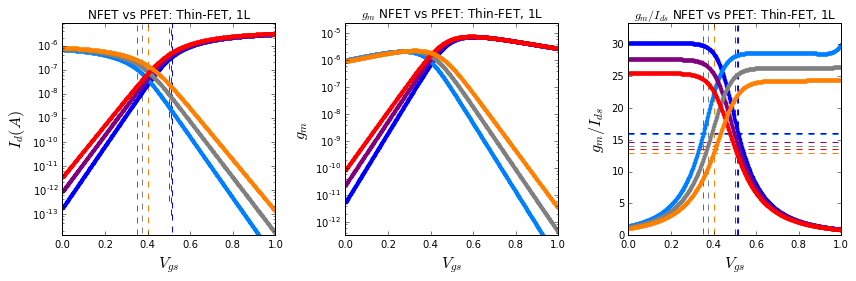

In [102]:
Vths_N_1L, IS_N_1L, Vths_P_1L, IS_P_1L = compareFETs(("NFET_1L", "PFET_1L"), 
            (folderRoot, folderRoot_P),
            "NFET vs PFET: Thin-FET, 1L",
            curveType="IdsVgsCurve")

## Plot slope factor $n$ ($\frac{1}{\kappa}$)

_Note: the mean, min, and max values shown are for the full measured range of values and not for the region that is being viewed using xLims()_
### Short-channel (150nm)

#### Thick-Oxide Slope Factor plots

------------NFET ThickOx 1L------------
Temp:  0.0
Mean SFs: 1.110770098 	Mean kappa: 0.900288097822
Min SFs: 1.0951387453 	Min kappa: 0.894994845349
Max SFs: 1.11732487086 	Max kappa: 0.913126308689
Temp:  25.0
Mean SFs: 1.11108022504 	Mean kappa: 0.900044489998
Min SFs: 1.08419970147 	Min kappa: 0.893959460603
Max SFs: 1.11861895765 	Max kappa: 0.922339305801
Temp:  50.0
Mean SFs: 1.11107138678 	Mean kappa: 0.9000724495
Min SFs: 1.06786367262 	Min kappa: 0.892930460072
Max SFs: 1.11990803844 	Max kappa: 0.936449123272
Fitted Gammas: [ 108.1064104    90.34977704    3.27192659]
Fitted V_fermis: [  1.19523827e+05   8.32744564e+04   1.10916464e+02]
None


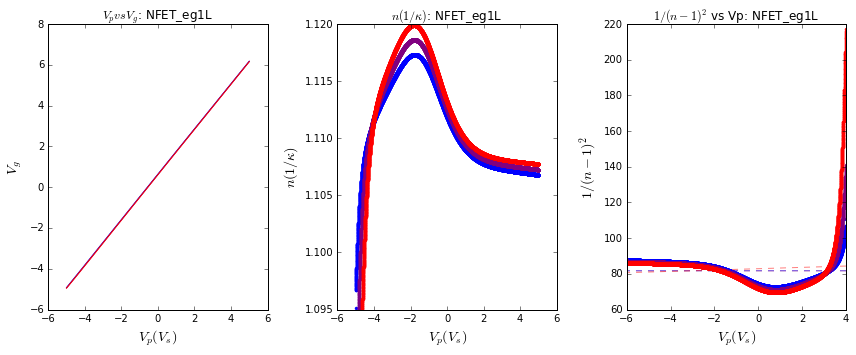

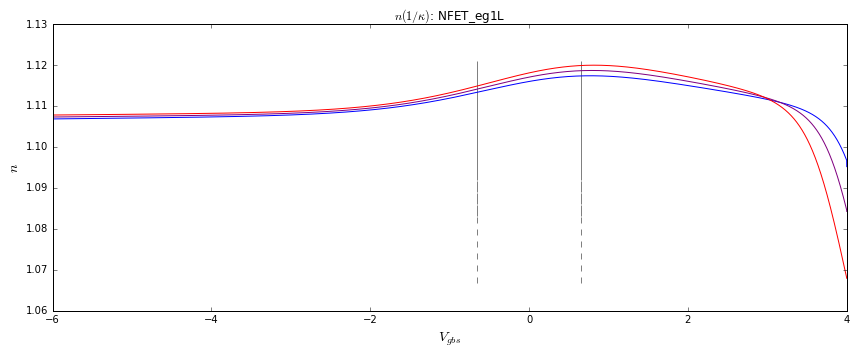

In [524]:
SFs,gammas,fermis = slopeFactor(folderRoot, FETType="NFET_eg1L", curveType="VgvsVs_KappaExtraction",
                  temps=temps, ttl="NFET_eg1L", xLims=None, yLims=None, printFN=False, plotIdx=0)
print "------------NFET ThickOx 1L------------\n", printSFInfo(temps,SFs,gammas,fermis)
show()
advSFInfo(folderRoot, FETType="NFET_eg1L", curveType="VgvsVs_KappaExtraction",
                  temps=temps, xLims=None, yLims=(1.108, 1.115),printFN=False, plotIdx=0, Vdd=1, Vth=0.65)


------------PFET ThickOx 1L------------
Temp:  0.0
Mean SFs: 1.12021347223 	Mean kappa: 0.892689759638
Min SFs: 1.11623611783 	Min kappa: 0.889527250204
Max SFs: 1.12419265376 	Max kappa: 0.895867804339
Temp:  25.0
Mean SFs: 1.120423529 	Mean kappa: 0.892522844578
Min SFs: 1.1158566298 	Min kappa: 0.88912749044
Max SFs: 1.12469810095 	Max kappa: 0.896172477088
Temp:  50.0
Mean SFs: 1.12066003255 	Mean kappa: 0.892334943403
Min SFs: 1.11534300286 	Min kappa: 0.888743165693
Max SFs: 1.12518446116 	Max kappa: 0.896585173739
Fitted Gammas: [ 82.40444626  84.97409562  87.66593766]
Fitted V_fermis: [ 58778.50031023  62291.59253815  66049.31492752]
None


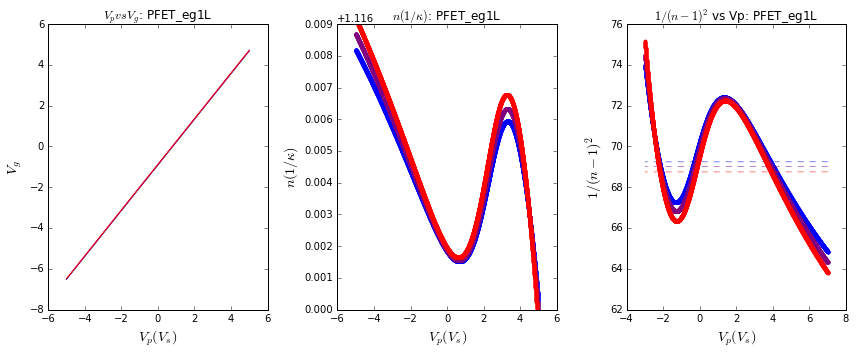

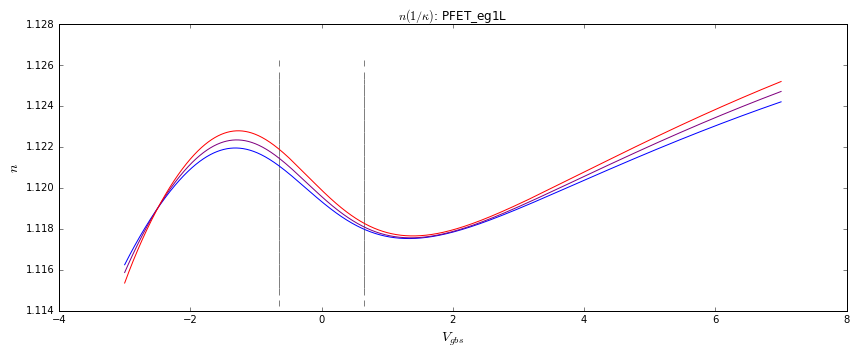

In [585]:
SFs,gammas,fermis = slopeFactor(folderRoot, FETType="PFET_eg1L", curveType="VgvsVs_KappaExtraction",
                  temps=temps, ttl="PFET_eg1L", xLims=None, yLims=None, printFN=False, plotIdx=0)
print "------------PFET ThickOx 1L------------\n", printSFInfo(temps,SFs,gammas,fermis)
show()
advSFInfo(folderRoot, FETType="PFET_eg1L", curveType="VgvsVs_KappaExtraction",
                  temps=temps, xLims=None, yLims=(1.108, 1.115),printFN=False, plotIdx=0, Vdd=1, Vth=0.65)

#### Thin-Oxide Slope Factor plots

------------NFET ThinOx 1L------------
Temp:  0.0
Mean SFs: 1.05144484581 	Mean kappa: 0.951072355093
Min SFs: 1.050719291 	Min kappa: 0.950552098653
Max SFs: 1.0520201906 	Max kappa: 0.951728980868
Temp:  25.0
Mean SFs: 1.05155430109 	Mean kappa: 0.950973363578
Min SFs: 1.05081391938 	Min kappa: 0.950443227937
Max SFs: 1.05214069668 	Max kappa: 0.951643275332
Temp:  50.0
Mean SFs: 1.05169019786 	Mean kappa: 0.950850483457
Min SFs: 1.05066553506 	Min kappa: 0.950316211498
Max SFs: 1.05228132268 	Max kappa: 0.951777674844
Fitted Gammas: [ 19.89560678  19.91683836  20.01698473]
Fitted V_fermis: [ 18697.17192509  18657.79849206  18746.97836674]
None


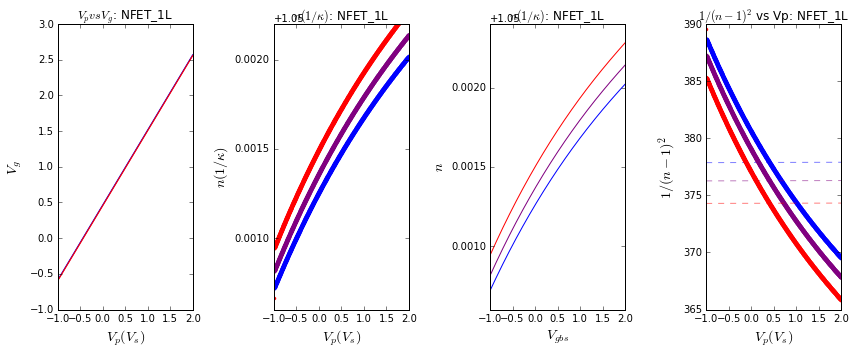

------------NFET ThinOx 1L Different Sweep Range------------
Temp:  0.0
Mean SFs: 1.05095356651 	Mean kappa: 0.951517020495
Min SFs: 1.05001232297 	Min kappa: 0.950858710421
Max SFs: 1.05168095853 	Max kappa: 0.952369775217
Temp:  25.0
Mean SFs: 1.05105292647 	Mean kappa: 0.951427078482
Min SFs: 1.05009161001 	Min kappa: 0.950755498579
Max SFs: 1.05179512661 	Max kappa: 0.952297866647
Temp:  50.0
Mean SFs: 1.05118272939 	Mean kappa: 0.951309598912
Min SFs: 1.05020736076 	Min kappa: 0.95063099662
Max SFs: 1.0519328778 	Max kappa: 0.952192907197
Fitted Gammas: [ 21.96460913  22.04519502  22.19465152]
Fitted V_fermis: [ 23232.77201503  23312.66327738  23510.37940122]
None


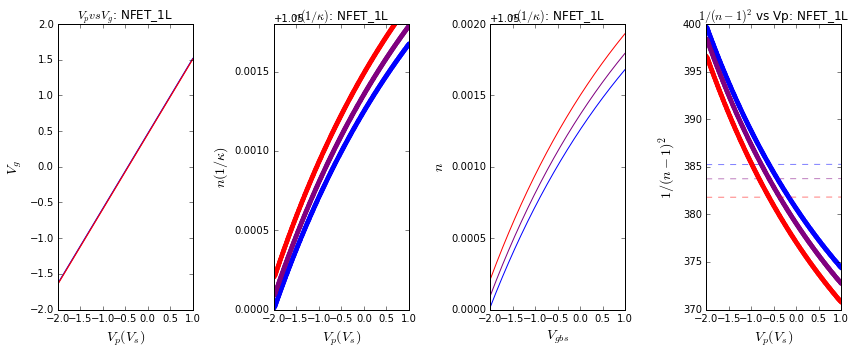

------------PFET ThinOx 1L------------
Temp:  0.0
Mean SFs: 1.06284007082 	Mean kappa: 0.940875433341
Min SFs: 1.06248353883 	Min kappa: 0.940185470385
Max SFs: 1.06361992553 	Max kappa: 0.941191052339
Temp:  25.0
Mean SFs: 1.06318807059 	Mean kappa: 0.940567470832
Min SFs: 1.06283244443 	Min kappa: 0.939862249861
Max SFs: 1.06398570657 	Max kappa: 0.940882079056
Temp:  50.0
Mean SFs: 1.06362303266 	Mean kappa: 0.940182825296
Min SFs: 1.06328066159 	Min kappa: 0.939487750135
Max SFs: 1.06440983382 	Max kappa: 0.940485458
Fitted Gammas: [ 1.12818827  1.1371006   1.17473689]
Fitted V_fermis: [ 40.04434977  40.2338985   42.36908488]
None


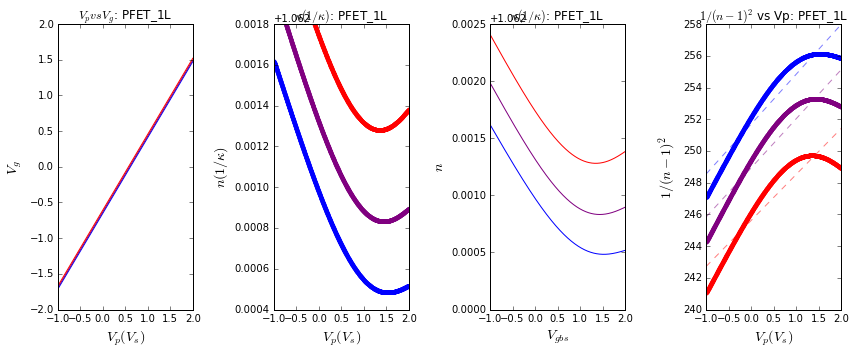

------------PFET ThinOx 1L Different Sweep Range------------
Temp:  0.0
Mean SFs: -1.06259090416 	Mean kappa: -0.941095966393
Min SFs: -1.06297434241 	Min kappa: -0.94119327474
Max SFs: -1.06248103003 	Max kappa: -0.940756479348
Temp:  25.0
Mean SFs: -1.06295992008 	Mean kappa: -0.940769254947
Min SFs: -1.06331769368 	Min kappa: -0.940882071226
Max SFs: -1.06283245327 	Max kappa: -0.940452703784
Temp:  50.0
Mean SFs: -1.06343104755 	Mean kappa: -0.940352470128
Min SFs: -1.06373926179 	Min kappa: -0.940486346069
Max SFs: -1.06327965757 	Max kappa: -0.940079995093
Fitted Gammas: [ 302.62589863  294.26192747  294.29590876]
Fitted V_fermis: [ 2690.12115586  2542.51973401  2541.94217089]
None


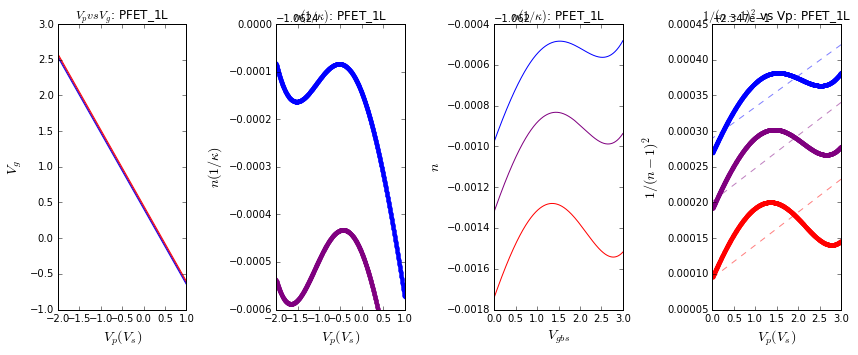

In [298]:
SFs,gammas,fermis = slopeFactor(folderRoot, FETType="NFET_1L", curveType="VgvsVs_KappaExtraction",
                  #temps=temps, xLims=(0,1), yLims=(1.11, 1.12), printFN=True)
                  temps=temps, ttl="NFET_1L", xLims=None, yLims=None, printFN=False, plotIdx=0)
print "------------NFET ThinOx 1L------------\n", printSFInfo(temps,SFs,gammas,fermis)
show()
SFs,gammas,fermis = slopeFactor(folderRoot, FETType="NFET_1L", curveType="VgvsVs_KappaExtraction1",
                  temps=temps, ttl="NFET_1L", xLims=None, yLims=None, printFN=False, plotIdx=0)
print "------------NFET ThinOx 1L Different Sweep Range------------\n", printSFInfo(temps,SFs,gammas,fermis)
show()
SFs,gammas,fermis = slopeFactor(folderRoot, FETType="PFET_1L", curveType="VgvsVs_KappaExtraction",
                  temps=temps, ttl="PFET_1L", xLims=None, yLims=None, printFN=False, plotIdx=0)
print "------------PFET ThinOx 1L------------\n", printSFInfo(temps,SFs,gammas,fermis)
show()
SFs,gammas,fermis = slopeFactor(folderRoot, FETType="PFET_1L", curveType="VgvsVs_KappaExtraction1",
                  temps=temps, ttl="PFET_1L", xLims=None, yLims=None, printFN=False, plotIdx=0)
print "------------PFET ThinOx 1L Different Sweep Range------------\n", printSFInfo(temps,SFs,gammas,fermis)

### Long-channel (450nm), Thick-Oxide

------------NFET ThickOx 3L------------
Temp:  0.0
Mean SFs: 1.10972110459 	Mean kappa: 0.901127903645
Min SFs: 1.10888760856 	Min kappa: 0.899366020538
Max SFs: 1.11189435354 	Max kappa: 0.901804648447
Temp:  25.0
Mean SFs: 1.11027389969 	Mean kappa: 0.900679365574
Min SFs: 1.10935566952 	Min kappa: 0.898727741182
Max SFs: 1.11268402451 	Max kappa: 0.901424157709
Temp:  50.0
Mean SFs: 1.11081804597 	Mean kappa: 0.900238278786
Min SFs: 1.10602719565 	Min kappa: 0.898125457973
Max SFs: 1.11343019076 	Max kappa: 0.904136900009
Fitted Gammas: [ 1.66010701  1.5945729   1.54982836]
Fitted V_fermis: [ 28.37146259  25.89333355  24.20572936]
None


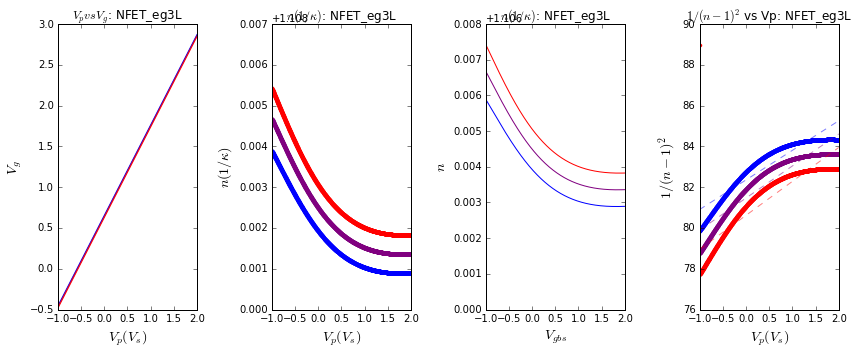

------------PFET ThickOx 3L------------
Temp:  0.0
Mean SFs: 1.12370931478 	Mean kappa: 0.889909963887
Min SFs: 1.12336075737 	Min kappa: 0.888988176817
Max SFs: 1.12487435275 	Max kappa: 0.890185982943
Temp:  25.0
Mean SFs: 1.12380196667 	Mean kappa: 0.889836618184
Min SFs: 1.12341987289 	Min kappa: 0.888822084762
Max SFs: 1.12508455533 	Max kappa: 0.890139140436
Temp:  50.0
Mean SFs: 1.12390856235 	Mean kappa: 0.889752250282
Min SFs: 1.12349101048 	Min kappa: 0.888638551192
Max SFs: 1.1253169229 	Max kappa: 0.890082778298
Fitted Gammas: [ 29.23417472  30.66843596  32.15863504]
Fitted V_fermis: [ 6980.10209972  7670.39327508  8419.49697177]
None


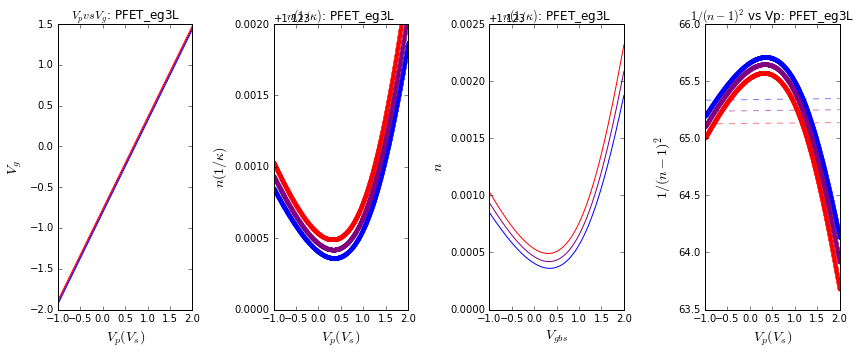

In [300]:
figsize(12,5)
SFs,gammas,fermis = slopeFactor(folderRoot, FETType="NFET_eg3L", curveType="VgvsVs_KappaExtraction",
                  temps=temps, xLims=None, yLims=(1.108, 1.115))
print "------------NFET ThickOx 3L------------\n", printSFInfo(temps,SFs,gammas,fermis)
show()
SFs,gammas,fermis = slopeFactor(folderRoot, FETType="PFET_eg3L", curveType="VgvsVs_KappaExtraction",
                  temps=temps, xLims=None, yLims=(1.123, 1.125))
print "------------PFET ThickOx 3L------------\n", printSFInfo(temps,SFs,gammas,fermis)

### Long-channel (1500nm), Thick-Oxide

------------NFET ThickOx 10L------------
Temp:  0.0
Mean SFs: 1.11003106183 	Mean kappa: 0.900876044297
Min SFs: 1.10657549431 	Min kappa: 0.899945756615
Max SFs: 1.11117808229 	Max kappa: 0.903688907934
Temp:  25.0
Mean SFs: 1.11051859139 	Mean kappa: 0.900481103984
Min SFs: 1.10246155943 	Min kappa: 0.899296336744
Max SFs: 1.11198051092 	Max kappa: 0.907061104711
Temp:  50.0
Mean SFs: 1.11075037024 	Mean kappa: 0.900295973965
Min SFs: 1.09282631526 	Min kappa: 0.898664481081
Max SFs: 1.11276235019 	Max kappa: 0.915058491946
Fitted Gammas: [ 34.54164959  28.64287549   4.66928205]
Fitted V_fermis: [ 12320.27510354   8398.93678693    222.99811091]
None


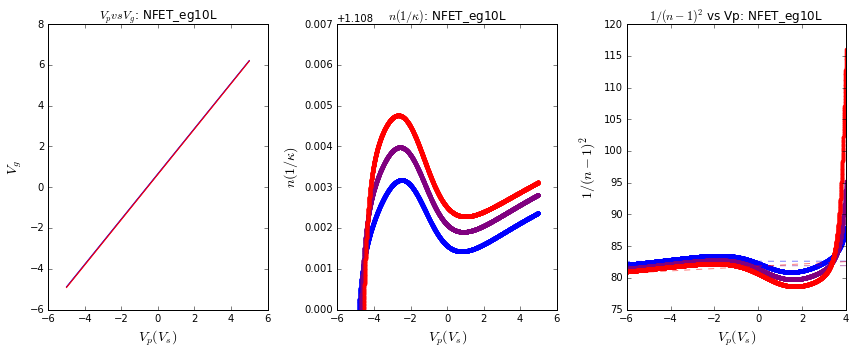

------------PFET ThickOx 10L------------
Temp:  0.0
Mean SFs: 1.12366841051 	Mean kappa: 0.889945157135
Min SFs: 1.12064848666 	Min kappa: 0.887128415167
Max SFs: 1.12723252114 	Max kappa: 0.89234047242
Temp:  25.0
Mean SFs: 1.12384684955 	Mean kappa: 0.889804277503
Min SFs: 1.12062714492 	Min kappa: 0.886833022962
Max SFs: 1.12760798719 	Max kappa: 0.89235746656
Temp:  50.0
Mean SFs: 1.12398202808 	Mean kappa: 0.88969772864
Min SFs: 1.12056649229 	Min kappa: 0.886601453364
Max SFs: 1.12790250479 	Max kappa: 0.892405766979
Fitted Gammas: [ 61.8204998   56.06111073  54.02081213]
Fitted V_fermis: [ 31258.65224969  25634.42945195  23753.59141625]
None


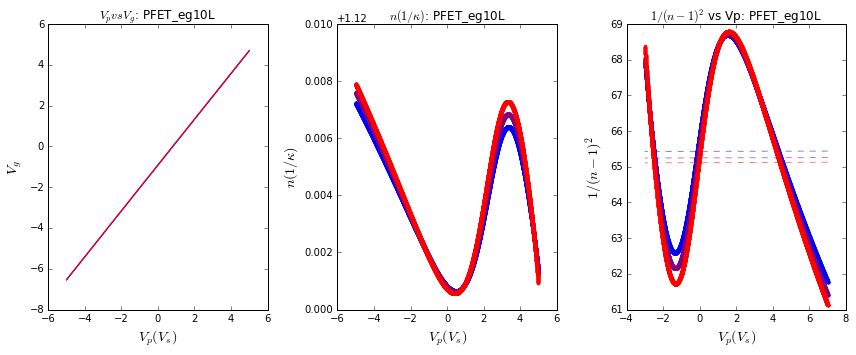

In [377]:
figsize(12,5)
SFs,gammas,fermis = slopeFactor(folderRoot, FETType="NFET_eg10L", curveType="VgvsVs_KappaExtraction",
                  temps=temps, xLims=None, yLims=(1.108, 1.115),printFN=False, plotIdx=0, Vdd=1, Vth=0.65)
print "------------NFET ThickOx 10L------------\n", printSFInfo(temps,SFs,gammas,fermis)
show()
SFs,gammas,fermis = slopeFactor(folderRoot, FETType="PFET_eg10L", curveType="VgvsVs_KappaExtraction",
                  temps=temps, xLims=None, yLims=(1.12, 1.13),printFN=False, plotIdx=0, Vth=0.65)
print "------------PFET ThickOx 10L------------\n", printSFInfo(temps,SFs,gammas,fermis)

#### Advanced SF Info

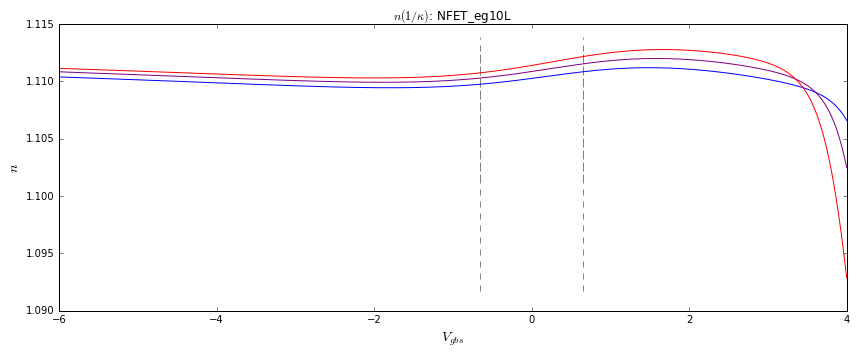

In [584]:
advSFInfo(folderRoot, FETType="NFET_eg10L", curveType="VgvsVs_KappaExtraction",
                  temps=temps, xLims=None, yLims=(1.108, 1.115),printFN=False, plotIdx=0, Vdd=1, Vth=0.65)

------------NFET ThickOx 10L------------
Temp:  0.0
Mean SFs: 0.900852110905 	Mean kappa: 1.11006048758
Min SFs: 0.899945756616 	Min kappa: 1.109427328
Max SFs: 0.901365934261 	Max kappa: 1.11117808229
Temp:  25.0
Mean SFs: 0.900390216326 	Mean kappa: 1.11063009614
Min SFs: 0.899296336393 	Min kappa: 1.10990520153
Max SFs: 0.900977848033 	Max kappa: 1.11198051135
Temp:  50.0
Mean SFs: 0.899993303688 	Mean kappa: 1.11112013025
Min SFs: 0.898664481082 	Min kappa: 1.11028265881
Max SFs: 0.900671547075 	Max kappa: 1.11276235019
Fitted Gammas: [ 2.79057333  2.54600202  2.31653411]
Fitted V_fermis: [ 99.02998673  81.67230365  67.08133687]
None


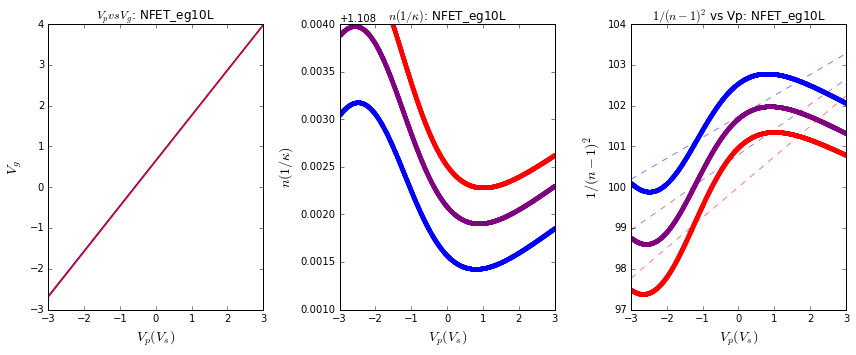

------------PFET ThickOx 10L------------
Temp:  0.0
Mean SFs: 0.890171180157 	Mean kappa: 1.12338346977
Min SFs: 0.8871284152 	Min kappa: 1.12064848667
Max SFs: 0.892340472408 	Max kappa: 1.12723252109
Temp:  25.0
Mean SFs: 0.890076377556 	Mean kappa: 1.12350362315
Min SFs: 0.886833023054 	Min kappa: 1.12062714493
Max SFs: 0.892357466555 	Max kappa: 1.12760798708
Temp:  50.0
Mean SFs: 0.890028279315 	Mean kappa: 1.12356481322
Min SFs: 0.886601453452 	Min kappa: 1.12056649234
Max SFs: 0.892405766938 	Max kappa: 1.12790250468
Fitted Gammas: [ 1.65962836  1.6150678   1.57775652]
Fitted V_fermis: [ 28.56331712  27.00575872  25.75196299]
None


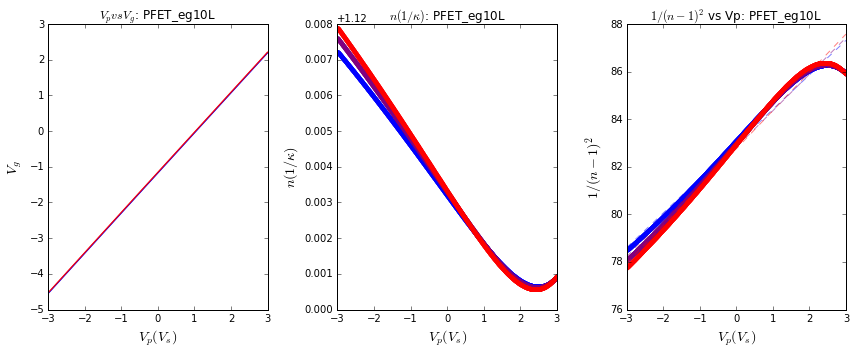

In [250]:
figsize(12,5)
SFs,gammas,fermis = slopeFactor(folderRoot, FETType="NFET_eg10L", curveType="VgvsVs_KappaExtraction_Vdd3V",
                  temps=temps, xLims=None, yLims=(1.109, 1.112))
print "------------NFET ThickOx 10L------------\n", printSFInfo(temps,SFs,gammas,fermis)
show()
SFs,gammas,fermis = slopeFactor(folderRoot, FETType="PFET_eg10L", curveType="VgvsVs_KappaExtraction_Vdd3V",
                  temps=temps, xLims=None, yLims=(1.12, 1.128))
print "------------PFET ThickOx 10L------------\n", printSFInfo(temps,SFs,gammas,fermis)

## Find and Plot the Early Voltages

In [ ]:
threshold = 0.6

figsize(12,10)
subplot(2,2,1)
ev_Vds, ev_Ids, EarlyVoltages, Ms, Bs = getEarlyVoltages(origVds_1L, origIds_1L_Vds, threshold)
plotIds((origVds_1L, origIds_1L_Vds), ttl="Thin-FET, 1L, Varying $V_{gs}$", xLbl='$V_{ds}$')
plotEarlyVTheory(ev_Vds, Ms, Bs, -4)

subplot(2,2,2)
ev_Vds, ev_Ids, EarlyVoltages, Ms, Bs = getEarlyVoltages(origVds_3L, origIds_3L_Vds, threshold)
plotIds((origVds_3L, origIds_3L_Vds), ttl="Thin-FET, 3L, Varying $V_{gs}$", xLbl='$V_{ds}$')
plotEarlyVTheory(ev_Vds, Ms, Bs, -6)

subplot(2,2,3)
ev_Vds, ev_Ids, EarlyVoltages, Ms, Bs = getEarlyVoltages(origVds_eg1L, origIds_eg1L_Vds, threshold)
plotIds((origVds_eg1L, origIds_eg1L_Vds), ttl="Thick-FET, 1L, Varying $V_{gs}$", xLbl='$V_{ds}$')
plotEarlyVTheory(ev_Vds, Ms, Bs, -10)

subplot(2,2,4)
ev_Vds, ev_Ids, EarlyVoltages, Ms, Bs = getEarlyVoltages(origVds_eg3L, origIds_eg3L_Vds, threshold)
plotIds((origVds_eg3L, origIds_eg3L_Vds), ttl="Thick-FET, 3L, Varying $V_{gs}$", xLbl='$V_{ds}$')
plotEarlyVTheory(ev_Vds, Ms, Bs, -16)

tight_layout()
show()

# Appendix

## Test  plotting of slope factors and extracting parameters

### Using actual data

/home/noza/work/Braindrop/CDB/BDTests/NFET_test/IV_Sim_Results/ParamExtract/NFET_VgvsVs_KappaExtraction_T0C.csv
Fitted Gamma: 0.845006695541 	 Fitted V_fermi: 7.13066949677
/home/noza/work/Braindrop/CDB/BDTests/NFET_test/IV_Sim_Results/ParamExtract/NFET_VgvsVs_KappaExtraction_T25C.csv
Fitted Gamma: 0.818758900172 	 Fitted V_fermi: 6.61675430316
/home/noza/work/Braindrop/CDB/BDTests/NFET_test/IV_Sim_Results/ParamExtract/NFET_VgvsVs_KappaExtraction_T50C.csv
Fitted Gamma: 0.800330513411 	 Fitted V_fermi: 6.24774072095


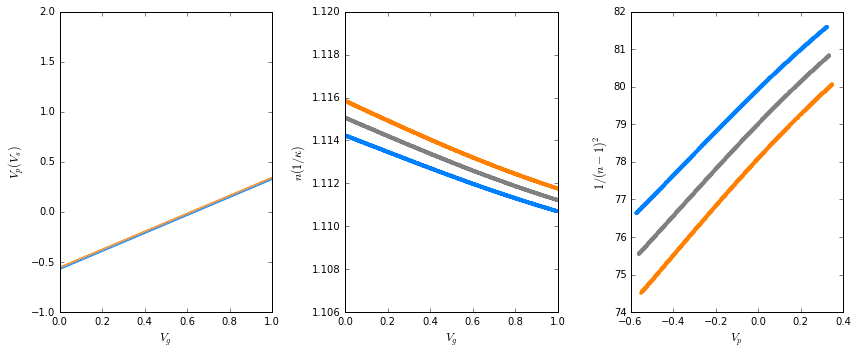

In [794]:
#from scipy.optimize import least_squares
FETType = "NFET"
curveType = "VgvsVs_KappaExtraction"
for i, curTemp in enumerate(temps):
    j=1
    Vps, Vgs = getData(folderRoot, FETType=FETType,
                                            CurveType=curveType, IDVal="T"+str(int(curTemp))+"C", printFN=True)
    subplot(1,3,1)
    #plotVpvsVg((Vgs[mask[:,i],2], Vps[mask[:,i],i]))
    plotVpvsVg((Vgs[:,2], Vps[:,i]),color=(1.*i/(numTemps-1), 1.*j/(numTemps-1), 1-(1.*i/(numTemps-1))))
    xlim((0,1))
    subplot(1,3,2)
    SFs = plotSlopeFactor((Vgs[:,2], Vps[:,i]),color=(1.*i/(numTemps-1), 1.*j/(numTemps-1), 1-(1.*i/(numTemps-1))))
    xlim((0,1))
    subplot(1,3,3)
    mask = where((Vgs[:,2]>=0)*(Vgs[:,2]<1))[0]
    #print "AAA", len(mask), mask
    #print "BBB", len(Vps[mask,i]), Vps[mask,i]
    #print "CCC", len(SFs[mask]), min(SFs[mask]), max(SFs[mask])
    gamma, vFermi = getSFParams(Vps[mask,i], calcInvNOffSq(SFs)[mask], (0.5, 0.2))
    invNOffSq = plotSFParamData((Vps[mask,i], SFs[mask]),color=(1.*i/(numTemps-1), 1.*j/(numTemps-1), 1-(1.*i/(numTemps-1))))
    #print invNOffSq
    #gamma, vFermi = getSFParams(Vps[mask,i], invNOffSq, (0.201, -10.1))
tight_layout()

### Using fabricated data

In [96]:
fooVgs = linspace(0,1,101)
fooVps = 0.9*(fooVgs-0.5)
#bar = linspace(1.1, 1.05, 101)
#print fooVgs, fooVps

# This is fake data testing to see if the leastsq algorithm is working
fooInvNSq = SFParamEq(fooVps, 0.5, 0.325)
#print "invNOffSq:", fooInvNSq
noise = np.random.normal(0,1,101)
#print noise
#print fooInvNSq+noise
noisyInvNOffSq = fooInvNSq+noise

#print ((1./fooInvNSq)**0.5)+1
fooGamma, fooFermiV = getSFParams(fooVps, noisyInvNOffSq, (0.5, 0.2))
print fooGamma, fooFermiV

0.505639704987 0.331551161409


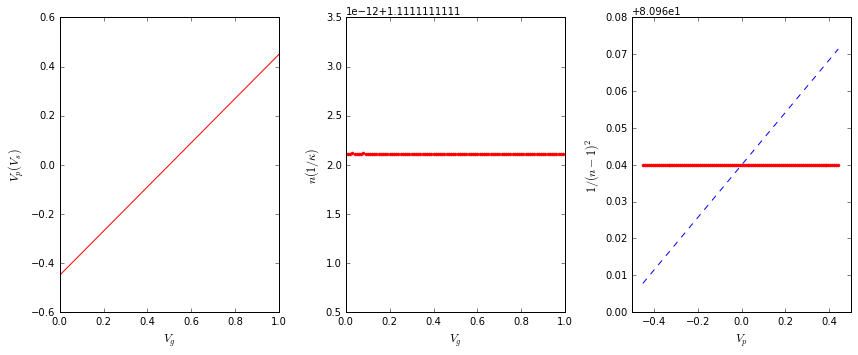

In [98]:
subplot(1,3,1)
plotVpvsVg((fooVgs, fooVps))
subplot(1,3,2)
fooSFs = plotSlopeFactor((fooVgs, fooVps))
#print fooSFs
subplot(1,3,3)
fooInvNSqs = plotSFParamData((fooVps[:-1], fooSFs))
#print fooInvNSqs
fooGamma, fooFermiV = getSFParams(fooVps[:-1], fooInvNSqs, (0.04, 0.3))
#print fooGamma, fooFermiV
#print SFParamEq(fooVps[:-1], fooGamma, fooFermiV)
plot(fooVps[:-1],SFParamEq(fooVps[:-1], fooGamma, fooFermiV),'--')

tight_layout()

## Test getIVal and getVVal methods

In [443]:
for a in arange(3):
    curveType = "IdsVgsCurve"
    FETType = "PFET_eg1L"
    xVals, yVals = getData(folderRoot_P, FETType=FETType,
                                            CurveType=curveType, IDVal="Vds"+str(Vds[a]))

    print IS_P_eg1L[a]/1.13, IS_P_eg1L[a], temps[a], Vds[a]
    Vgs = getVVal(IS_P_eg1L[a]/1.13, xVals[:,a], yVals[:,a])
    Id = getIVal(Vgs, xVals[:,a], yVals[:,a])
    print Vgs, Id*1.13

#    FETType = "NFET_eg1L"
#    xVals, yVals = getData(folderRoot, FETType=FETType,
#                                            CurveType=curveType, IDVal="Vds"+str(Vds[a]))
#    print IS_N_eg1L[a]/1.13, IS_N_eg1L[a], temps[a], Vds[a]
#    Vgs = getVVal(array(IS_N_eg1L[a])/1.13, xVals[:,a], yVals[:,a])
#    Id = getIVal(Vgs, xVals[:,a], yVals[:,a])
#    print Vgs, Id

/home/noza/work/Braindrop/CDB/BDTests/PFET_test/IV_Sim_Results/ExtractParams/PFET_eg1L_IdsVgsCurve_Vds0.012.csv
2.7455856672e-08 3.10251180393e-08 0.0 0.012
0.312 3.10251180393e-08
/home/noza/work/Braindrop/CDB/BDTests/PFET_test/IV_Sim_Results/ExtractParams/PFET_eg1L_IdsVgsCurve_Vds0.013.csv
3.06940287421e-08 3.46842524786e-08 25.0 0.013
0.334 3.46842524786e-08
/home/noza/work/Braindrop/CDB/BDTests/PFET_test/IV_Sim_Results/ExtractParams/PFET_eg1L_IdsVgsCurve_Vds0.014.csv
3.36264050904e-08 3.79978377521e-08 50.0 0.014
0.356 3.79978377521e-08


## Print permutations of Vds and temp sweeps to get all values
Print all permutations of Vds and temp sweeps to ensure I'm grabbing the correct values from my CompareFETs sweep

Note: I am!! :-D

[0.65300000000000047, 0.64100000000000046, 0.62600000000000044]
[1.2139880527590557e-07, 1.3843537536339645e-07, 1.4828965266114836e-07]
Vd: 0.012
/home/noza/work/Braindrop/CDB/BDTests/PFET_test/IV_Sim_Results/ExtractParams/PFET_eg1L_IdsVgsCurve_Vds0.012.csv
Temp: 0.0
Vt( 0.0 ):  0.312
IS( 0.0 ):  2.7455856672e-08 3.10251180393e-08
Temp: 25.0
Vt( 25.0 ):  0.335
IS( 25.0 ):  2.81387050753e-08 3.1796736735e-08
Temp: 50.0
Vt( 50.0 ):  0.357
IS( 50.0 ):  2.88675714894e-08 3.2620355783e-08


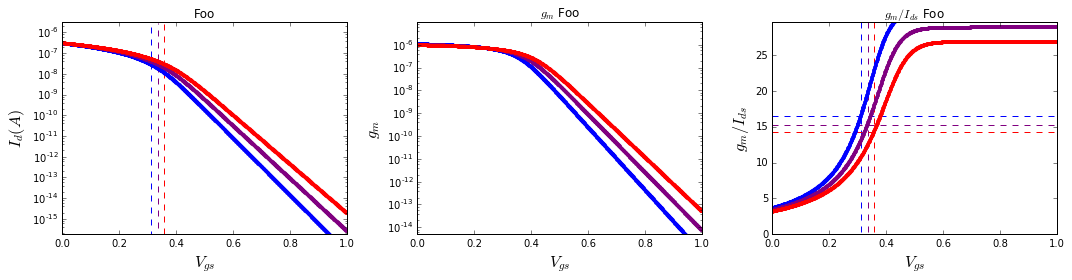

Vd: 0.013
/home/noza/work/Braindrop/CDB/BDTests/PFET_test/IV_Sim_Results/ExtractParams/PFET_eg1L_IdsVgsCurve_Vds0.013.csv
Temp: 0.0
Vt( 0.0 ):  0.311
IS( 0.0 ):  2.99655153546e-08 3.38610323507e-08
Temp: 25.0
Vt( 25.0 ):  0.334
IS( 25.0 ):  3.06940287421e-08 3.46842524786e-08
Temp: 50.0
Vt( 50.0 ):  0.356
IS( 50.0 ):  3.14736313472e-08 3.55652034224e-08


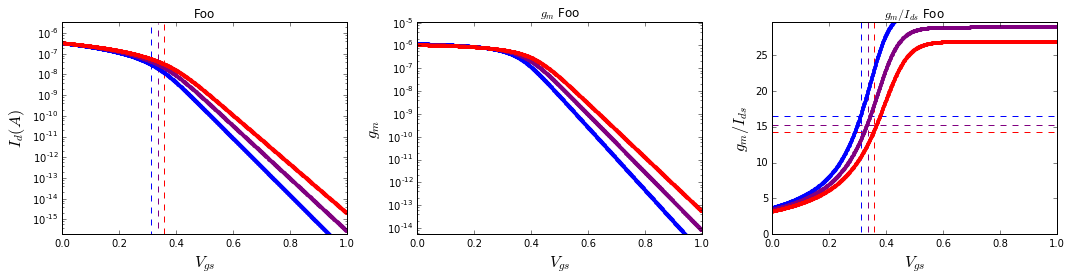

Vd: 0.014
/home/noza/work/Braindrop/CDB/BDTests/PFET_test/IV_Sim_Results/ExtractParams/PFET_eg1L_IdsVgsCurve_Vds0.014.csv
Temp: 0.0
Vt( 0.0 ):  0.311
IS( 0.0 ):  3.19734682756e-08 3.61300191514e-08
Temp: 25.0
Vt( 25.0 ):  0.333
IS( 25.0 ):  3.32825606139e-08 3.76092934937e-08
Temp: 50.0
Vt( 50.0 ):  0.356
IS( 50.0 ):  3.36264050904e-08 3.79978377521e-08


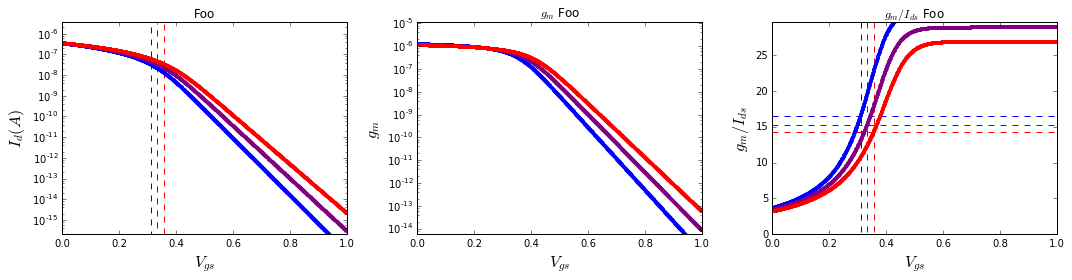

In [444]:
print Vths_N_eg1L
print IS_N_eg1L
FETType = "PFET_eg1L"
curveType = "IdsVgsCurve"


for j, Vd in enumerate(Vds):
    print "Vd:", Vd
    xVals, yVals = getData(folderRoot_P, FETType=FETType,
                                            CurveType=curveType, IDVal="Vds"+str(Vd))
    numTemps = shape(yVals)[1]
    for i, temp in enumerate(temps):
        print "Temp:", temp
        curVgs = xVals[:,i]
        curIds = yVals[:,i]
        #print curIds
        curGms = calcGm(curVgs, curIds)
        #print curGms
        curGmOverId = calcGmOverId(curGms, curIds[:-1])
        #print calcGmOverId(curGms, curIds[:-1])
        
        Vth, halfGmOverId  = calcVth(curVgs, curGmOverId)
        print "Vt(", temp,"): ", Vth
        curIS = calcIS(Vth, curVgs, curIds)[0]
        print "IS(",temp,"): ", curIS/1.13, curIS
        a, b, c, d = plotVgPlots(curVgs, curIds, "Foo", 
                    color=(1.*i/(numTemps-1), 0, 1-(1.*i/(numTemps-1))))
    show()

## Fit the subthreshold region for parameters

In [ ]:
temp = 25
print Vds
print xData
print yData

popt, pcov = leastsq(Ids_NFET_Err, (0.7, 0.6, -9, 0.05), args=(xData, yData, Vds, temp))
kappa = popt[0]
gam = popt[1]
Kd = popt[2]
lamda = popt[3]